<a href="https://colab.research.google.com/github/musicjae/intro_to_python/blob/master/Pytorch/NLP/3_CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고: https://github.com/rguthrie3/DeepLearningForNLPInPytorch/blob/master/Deep%20Learning%20for%20Natural%20Language%20Processing%20with%20Pytorch.ipynb

CBOW is distinct from language modeling, since CBOW is not sequential and does not have to be probabilistic. Typcially, CBOW is used to quickly train word embeddings, and these embeddings are used to initialize the embeddings of some more complicated model.

The CBOW model is as follows. Given a target word $w_i$ and an $N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$ and $w_{i+1}, \dots, w_{i+N}$, referring to all context words collectively as $C$, CBOW tries to minimize$$ -\log p(w_i | C) = \log \text{Softmax}(A(\sum_{w \in C} q_w) + b) $$where $q_w$ is the embedding for word $w$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

[text 출처]('https://www.yna.co.kr/view/AKR20201210086400009?section=international/all')

In [40]:
CONTEXT_SIZE = 4 
EMBEDDING_SIZE= 32

raw_text = """공화·민주 양당 의원이 참여한 9천80억달러(약 986조원) 규모의 '2020 코로나19 긴급 부양법안'에 이 같은 실업 보조금 지급 방안이 포함됐다고 CNBC 방송 9일(현지시간) 보도했다.

법안에는 현재 받는 지원금과는 별개로 12월 말부터 내년 4월 말까지 16주 동안 주당 300달러(약 32만원)의 실업자 보조금 지급안이 담겼다.

다만, 현 실업수당에 더해 지급될 보조금의 구체적인 지급 날짜는 언급되지 않았다.


노동부 통계에 따르면 10월 기준 미국 정부가 지급하는 평균 실업수당은 주당 320달러다. 다만 실업수당이 주당 5달러에 그친 주도 있다.

상원은 또 이달 마지막 주말에 기한이 만료되는 실업보험 보조금도 역시 16주 동안 추가로 지급하는 방안도 제안했다.

코로나19로 영향을 받은 자영업자와 중소영업장 근로자, 프리랜서 등 실업수당 지원 제외 대상자에게는 '팬데믹 실업 지원'(PUA)과 '팬데믹 긴급실업수당(PEUC) 지급도 최장 13주간 연장하는 방안도 제시됐다.

이들 혜택을 받게 될 취약계층은 전체 실업자의 3분의 2에 해당하는 1천300만 명에 이른다.""".split()
word_to_ix = { word: i for i, word in enumerate(set(raw_text)) }
ix_to_word = {i:word for i,word in enumerate(set(raw_text))}
data = []
for i in range(2, len(raw_text) - 2):
    context = [ raw_text[i-2], raw_text[i-1], raw_text[i+1], raw_text[i+2] ]
    target = raw_text[i]
    data.append( (context, target) )
print(data[:5])
VOCAB_SIZE = len(set(raw_text))

[(['공화·민주', '양당', '참여한', '9천80억달러(약'], '의원이'), (['양당', '의원이', '9천80억달러(약', '986조원)'], '참여한'), (['의원이', '참여한', '986조원)', '규모의'], '9천80억달러(약'), (['참여한', '9천80억달러(약', '규모의', "'2020"], '986조원)'), (['9천80억달러(약', '986조원)', "'2020", '코로나19'], '규모의')]


In [42]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size):
        super(CBOW,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size*context_size, 64)
        self.linear2 = nn.Linear(64, vocab_size)

    def forward(self,inputs):
        x = self.embedding(inputs).view((1,-1))
        x = F.relu(x)
        x = F.relu(self.linear(x))
        x = F.log_softmax(self.linear2(x))

        return x

In [43]:
model = CBOW(VOCAB_SIZE,EMBEDDING_SIZE,CONTEXT_SIZE)
print(model)

CBOW(
  (embedding): Embedding(113, 32)
  (linear): Linear(in_features=128, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=113, bias=True)
)


In [14]:
for param in model.parameters():
    print(param.shape)

torch.Size([113, 16])
torch.Size([64, 32])
torch.Size([64])
torch.Size([113, 64])
torch.Size([113])


## utils

In [44]:
def make_context_vector(context, word_to_ix):
    idxs = list(map(lambda w: word_to_ix[w], context))
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

print(make_context_vector(data[0][0], word_to_ix)) # example
print(data[0][0])
print(ix_to_word[70],ix_to_word[74],ix_to_word[75],ix_to_word[13])

tensor([70, 74, 75, 13])
['공화·민주', '양당', '참여한', '9천80억달러(약']
공화·민주 양당 참여한 9천80억달러(약


In [46]:
losses = []
epochs = []

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    total_loss = torch.Tensor([0])
    for ctx, target in data:
        input_data = make_context_vector(ctx,word_to_ix)

        model.zero_grad()
        predictions = model(input_data)
        loss = loss_fn(predictions, autograd.Variable(torch.LongTensor([word_to_ix[target]])))

        loss.backward()
        optimizer.step()

        total_loss += loss.data
    losses.append(total_loss.item())
    if epoch % 10 == 0:
        epochs.append(epoch)
        print(f'Epoch: {epoch}')
        print(f'  loss: {total_loss.item()}')
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 0
  loss: 572.94921875
Epoch: 10
  loss: 4.6993560791015625
Epoch: 20
  loss: 0.9091975688934326
Epoch: 30
  loss: 0.32865235209465027
Epoch: 40
  loss: 0.14326675236225128
Epoch: 50
  loss: 0.0676746666431427
Epoch: 60
  loss: 0.03332846984267235
Epoch: 70
  loss: 0.016775736585259438
Epoch: 80
  loss: 0.008555074222385883
Epoch: 90
  loss: 0.00440147565677762


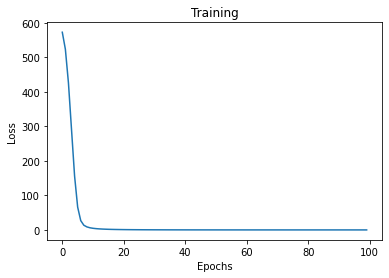

In [47]:
plt.title('Training')
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [48]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.0026e+00, -5.2364e-03,  7.7003e-01,  ..., -1.1951e-02,
         -3.3244e-01,  1.1951e+00],
        [-1.7780e-01,  5.5054e-01, -6.6319e-02,  ..., -2.3858e-01,
         -2.7820e+00,  4.7581e-01],
        [-1.2531e-01, -5.7280e-01, -2.1951e-01,  ..., -1.3314e+00,
         -2.9937e-02, -1.7079e-01],
        ...,
        [-2.2184e+00,  8.4705e-01, -7.2615e-03,  ...,  2.7064e-01,
          9.9539e-01,  1.8244e+00],
        [-1.7891e+00, -2.8514e-01, -9.2926e-05,  ...,  1.0939e+00,
         -2.7649e-04,  2.7731e-01],
        [-2.2860e-01,  1.3320e+00, -1.3727e-01,  ...,  7.0118e-02,
         -5.3068e-02,  2.7356e-01]], requires_grad=True)
Parameter containing:
tensor([[ 0.1250, -0.0269,  0.1931,  ..., -0.1447, -0.3130,  0.0297],
        [ 0.0329,  0.0828,  0.0932,  ...,  0.0435,  0.1451,  0.1282],
        [-0.0599,  0.0050, -0.0396,  ...,  0.2248,  0.0487,  0.2173],
        ...,
        [ 0.0186,  0.0475,  0.1970,  ...,  0.0474, -0.2160,  0.0364],
        [-0